https://coderzcolumn.com/tutorials/artificial-intelligence/pytorch-lstm-for-text-classification-tasks

In [1]:
! pip install scikit-plot

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import json

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(1)

In [3]:
df = pd.read_csv("https://docs.google.com/spreadsheets/d/1BKNwZcdat_-8dqh2-FgmmAzRNQBcAfzBV_bPV2wSuwI/export?gid=0&format=csv")

In [4]:
tasks = {v:k for k,v in dict(enumerate(list(df.event_type.unique()))).items()}
print(tasks)

{'advice': 0, 'task_create': 1}


In [5]:
flipped_tasks = {v:k for k,v in tasks.items()}
flipped_tasks

{0: 'advice', 1: 'task_create'}

In [6]:
df.head(5)

,Message,event_type
0,Как создать новую задачу в WEEEK?,advice
1,Как назначить ответственного за задачу в WEEEK?,advice
2,Как установить срок выполнения задачи в WEEEK?,advice
3,Как добавить описание к задаче в WEEEK?,advice
4,Как прикрепить файл к задаче в WEEEK?,advice


In [7]:
df.tail(5)

,Message,event_type
2771,Провести конкурс ко Дню космонавтики с призовы...,task_create
2772,Разработать 10 вариантов обложек для видео с с...,task_create
2773,Придумать 20 идей ежедневных рубрик в ТикТок н...,task_create
2774,Спланировать съемки для 10 рецептов коктейлей ...,task_create
2775,Провести промо товаров среди подписчиков и про...,task_create


In [8]:
len(df)

2776

In [9]:
# Очень неравномерные классы
df.groupby('event_type').size()

event_type
advice         2438
task_create     338
dtype: int64

In [10]:
df['rank'] = df.groupby('event_type').rank()
df[df['rank']==10]

,Message,event_type,rank
364,"""Как оценить проектный бюджет и затраты?""",advice,10.0
2636,"Анна Кузнецова, разработайте лендинг для продв...",task_create,10.0


In [11]:
df['type'] = np.where(df['rank']<10, 'test', 'train')

In [12]:
ds_vocab = dict()

for sent in df['Message'].str.split():
    for word in sent:
        word = word.lower()
        for letter in word:
          if not letter.isalpha() and not letter.isnumeric():
            word=word.replace(letter, "")
        if word not in ds_vocab:  # word has not been assigned an index yet
            ds_vocab[word] = len(ds_vocab)  # Assign each word with a unique index
print(ds_vocab)
print(len(ds_vocab)) #3208


{'как': 0, 'создать': 1, 'новую': 2, 'задачу': 3, 'в': 4, 'weeek': 5, 'назначить': 6, 'ответственного': 7, 'за': 8, 'установить': 9, 'срок': 10, 'выполнения': 11, 'задачи': 12, 'добавить': 13, 'описание': 14, 'к': 15, 'задаче': 16, 'прикрепить': 17, 'файл': 18, 'проект': 19, 'существующий': 20, 'какие': 21, 'виды': 22, 'задач': 23, 'поддерживает': 24, 'например': 25, 'проекты': 26, 'события': 27, 'организовать': 28, 'по': 29, 'категориям': 30, 'или': 31, 'меткам': 32, 'могу': 33, 'ли': 34, 'я': 35, 'приоритет': 36, 'для': 37, 'отметить': 38, 'завершенную': 39, 'отслеживать': 40, 'прогресс': 41, 'проектов': 42, 'список': 43, 'подобный': 44, 'списку': 45, 'trello': 46, 'доску': 47, 'с': 48, 'задачами': 49, 'чеклист': 50, 'уведомления': 51, 'работают': 52, 'настроить': 53, 'напоминания': 54, 'о': 55, 'задачах': 56, 'и': 57, 'событиях': 58, 'можно': 59, 'экспортировать': 60, 'из': 61, 'другие': 62, 'форматы': 63, 'csv': 64, 'функции': 65, 'синхронизации': 66, 'доступны': 67, 'между': 68, '

In [13]:
def clean_sentence(sent):
  sent = sent.split()
  clean_sent = list()
  for word in sent:
    word = word.lower()
    for letter in word:
      if not letter.isalpha() and not letter.isnumeric():
        word=word.replace(letter, "")
    clean_sent.append(word)
  return clean_sent

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [15]:
class MyDataset(Dataset):
    def __init__(self, df, max_words, vocab, ds_type):
        super(MyDataset, self).__init__()
        self.df = df
        self.ds_type = ds_type
        self.max_words = max_words
        self.vocab = vocab
        self.sentences=[]
        self.labels=[]
        videos = []
        for i,row in df[df["type"]==ds_type].iterrows():
            sentence = clean_sentence(row['Message'])
            task_id = row['event_type']
            self.sentences.append(sentence)
            self.labels.append(task_id)

    def __getitem__(self, index):
        sent = prepare_sequence(self.sentences[index], self.vocab)
        label=self.labels[index]
        return sent, tasks[self.labels[index]]


    def __len__(self):
        return len(self.sentences)

In [16]:
train_dataloader = DataLoader(MyDataset(df, max_words=25, vocab=ds_vocab, ds_type='train'), batch_size=1, shuffle=True)
test_dataloader = DataLoader(MyDataset(df, max_words=25, vocab=ds_vocab, ds_type='test'), batch_size=1, shuffle=True)

In [17]:
for X, Y in train_dataloader:
    print(X.shape, Y.shape)
    break

torch.Size([1, 12]) torch.Size([1])


In [18]:
embed_len = 50
hidden_dim = 75
n_layers=1

# Create the model:
class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(ds_vocab), embedding_dim=embed_len)
        self.lstm = nn.LSTM(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(tasks))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        hidden, carry = torch.randn(n_layers, len(X_batch), hidden_dim), torch.randn(n_layers, len(X_batch), hidden_dim)
        output, (hidden, carry) = self.lstm(embeddings, (hidden, carry))
        return self.linear(output[:,-1])

In [19]:
lstm_classifier = LSTMClassifier()
lstm_classifier

LSTMClassifier(
  (embedding_layer): Embedding(3208, 50)
  (lstm): LSTM(50, 75, batch_first=True)
  (linear): Linear(in_features=75, out_features=2, bias=True)
)

In [20]:
for layer in lstm_classifier.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(3208, 50)
Parameters : 
torch.Size([3208, 50])

Layer : LSTM(50, 75, batch_first=True)
Parameters : 
torch.Size([300, 50])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])

Layer : Linear(in_features=75, out_features=2, bias=True)
Parameters : 
torch.Size([2, 75])
torch.Size([2])



In [21]:
out = lstm_classifier(torch.randint(0, len(ds_vocab), (1024, 100)))
out.shape

torch.Size([1024, 2])

In [22]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)
        test_loss = torch.tensor(losses).mean()
        acc_score = accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())
        print("Valid Loss : {:.3f}".format(test_loss))
        print("Valid Acc  : {:.3f}".format(acc_score))
        return test_loss, acc_score


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    train_losses = list()
    test_losses = list()
    acc_scores = list()
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X) ## Make Predictions

            loss = loss_fn(Y_preds, Y) ## Calculate Loss
            losses.append(loss.item())

            optimizer.zero_grad() ## Clear previously calculated gradients
            loss.backward() ## Calculates Gradients
            optimizer.step() ## Update network weights.
        train_loss = torch.tensor(losses).mean()
        print("Train Loss : {:.3f}".format(train_loss))
        test_loss, acc_score = CalcValLossAndAccuracy(model, loss_fn, val_loader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        acc_scores.append(acc_score)
    return train_losses, test_losses, acc_scores

In [23]:
from torch.optim import Adam

epochs = 10
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
lstm_classifier = LSTMClassifier()
optimizer = Adam(lstm_classifier.parameters(), lr=learning_rate)

train_losses, test_losses, acc_scores = TrainModel(lstm_classifier, loss_fn, optimizer, train_dataloader, test_dataloader, epochs)

100%|██████████| 2758/2758 [00:25<00:00, 107.45it/s]


Train Loss : 0.105
Valid Loss : 0.085
Valid Acc  : 0.944


100%|██████████| 2758/2758 [00:16<00:00, 169.44it/s]


Train Loss : 0.015
Valid Loss : 0.003
Valid Acc  : 1.000


100%|██████████| 2758/2758 [00:15<00:00, 174.73it/s]


Train Loss : 0.007
Valid Loss : 0.000
Valid Acc  : 1.000


100%|██████████| 2758/2758 [00:13<00:00, 200.28it/s]


Train Loss : 0.000
Valid Loss : 0.000
Valid Acc  : 1.000


100%|██████████| 2758/2758 [00:15<00:00, 183.04it/s]


Train Loss : 0.001
Valid Loss : 0.000
Valid Acc  : 1.000


100%|██████████| 2758/2758 [00:15<00:00, 175.17it/s]


Train Loss : 0.002
Valid Loss : 0.000
Valid Acc  : 1.000


100%|██████████| 2758/2758 [00:16<00:00, 162.90it/s]


Train Loss : 0.000
Valid Loss : 0.089
Valid Acc  : 0.944


100%|██████████| 2758/2758 [00:16<00:00, 169.84it/s]


Train Loss : 0.000
Valid Loss : 0.000
Valid Acc  : 1.000


100%|██████████| 2758/2758 [00:17<00:00, 154.15it/s]


Train Loss : 0.000
Valid Loss : 0.000
Valid Acc  : 1.000


100%|██████████| 2758/2758 [00:16<00:00, 171.66it/s]


Train Loss : 0.000
Valid Loss : 0.000
Valid Acc  : 1.000


In [24]:
targets = list()
predictions = list()
for X, Y in test_dataloader:
  out = lstm_classifier(X)
  pred = list(max(out)).index(max(max(out)).item())
  targets.append(Y.item())
  predictions.append(pred)
  print(f"Y: {Y.item()}, Out: {pred}")

Y: 1, Out: 1
Y: 1, Out: 1
Y: 0, Out: 0
Y: 1, Out: 1
Y: 1, Out: 1
Y: 0, Out: 0
Y: 1, Out: 1
Y: 0, Out: 0
Y: 0, Out: 0
Y: 0, Out: 0
Y: 1, Out: 1
Y: 1, Out: 1
Y: 0, Out: 0
Y: 0, Out: 0
Y: 1, Out: 1
Y: 0, Out: 0
Y: 0, Out: 0
Y: 1, Out: 1


In [25]:
train_losses

[tensor(0.1051),
 tensor(0.0153),
 tensor(0.0072),
 tensor(0.0004),
 tensor(0.0013),
 tensor(0.0015),
 tensor(1.1929e-05),
 tensor(3.0324e-06),
 tensor(4.7503e-06),
 tensor(1.0335e-06)]

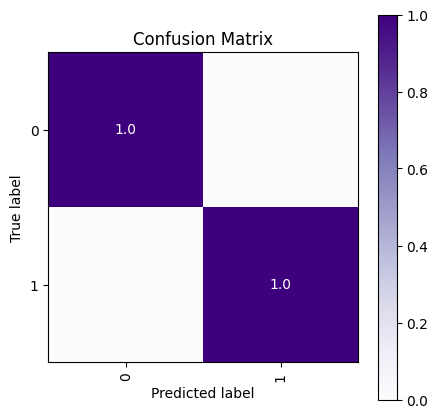

In [26]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_confusion_matrix(targets, predictions,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

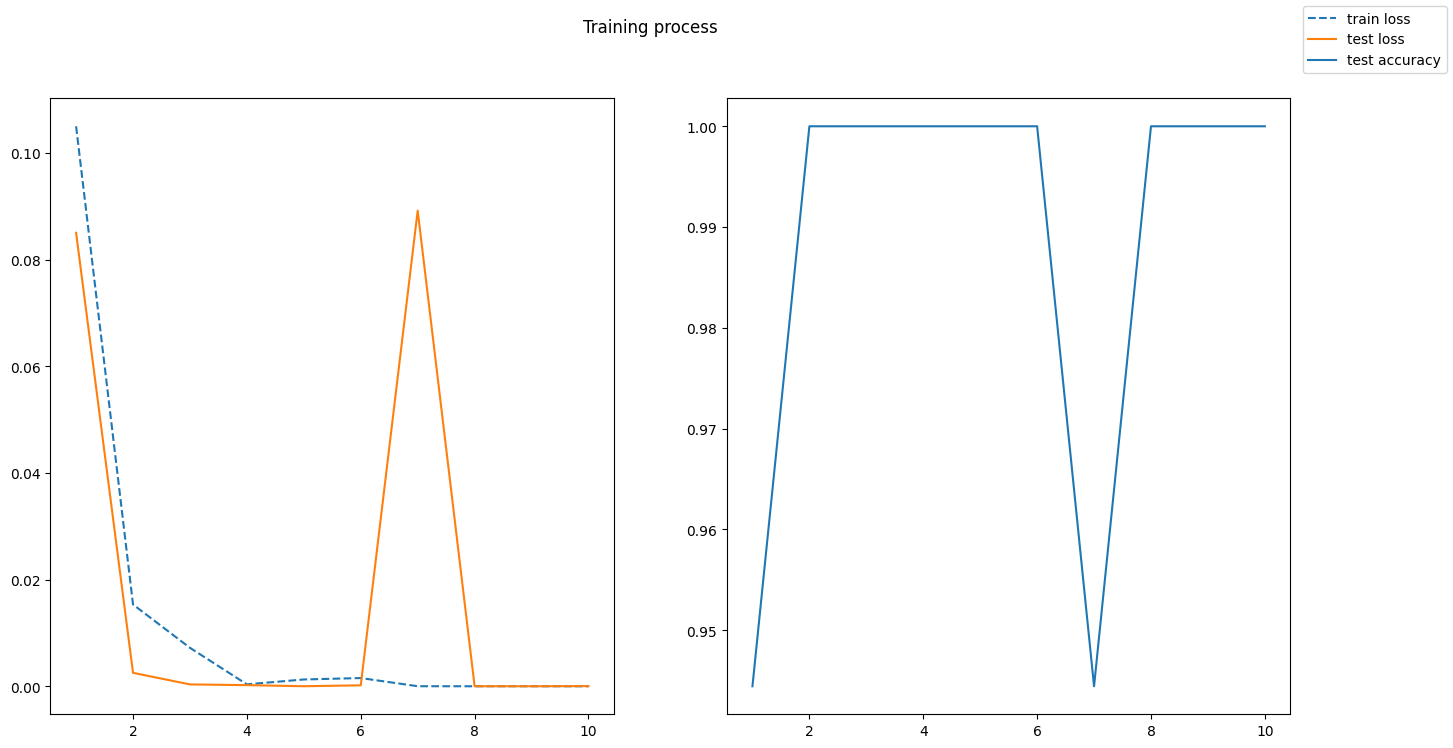

In [41]:
t = range(1, epochs + 1, 1)

#train_losses, test_losses, acc_scores
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16, 8))
ax[0].plot(t, train_losses, label = "train loss", linestyle="--")
ax[0].plot(t, test_losses, label = "test loss")
ax[1].plot(t, acc_scores, label = "test accuracy")
fig.suptitle("Training process")
fig.legend()
plt.show()

In [83]:
# Сохраним модель
torch.save(lstm_classifier, "LSTM_classifier.pth")

# Сохраним словарь
with open('vocab.json', 'w') as f:
  f.write(json.dumps(ds_vocab))

# Сохраним типы задач
with open('flipped_tasks.json', 'w') as f:
  f.write(json.dumps(flipped_tasks))

# Применение модели

In [ ]:
# Вспомогательные функции
def clean_sentence(sent):
  sent = sent.split()
  clean_sent = list()
  for word in sent:
    word = word.lower()
    for letter in word:
      if not letter.isalpha() and not letter.isnumeric():
        word=word.replace(letter, "")
    clean_sent.append(word)
  return clean_sent

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [84]:
# Загрузим модель
model = torch.load("LSTM_classifier.pth")
model.eval()

# Загрузим словарь
with open('vocab.json', 'r') as f:
  vacab = json.load(f)

# Загрузим типы задач
with open('flipped_tasks.json', 'r') as f:
  flipped_tasks = json.load(f)

In [87]:
example = 'Как установить срок выполнения задачи в WEEEK?'
def get_result(example):
  example = clean_sentence(example)
  input = prepare_sequence(example, vacab)
  out = model(input[None, :])
  pred = list(max(out)).index(max(max(out)).item())
  return flipped_tasks[str(pred)]

get_result(example)

'advice'

In [66]:
examples = list()
for i, row in df[df['type']=='test'].iterrows():
  examples.append(row["Message"])

In [68]:
for example in examples:
  print(f"{example}  =>  {get_result(example)}")

"Как организовать проект и добавиь в него задачки?"  =>  advice
"Как настроить автоматическое назначение задач на основе приоритета?"  =>  advice
"Как настроить интеграцию с системами учета рабочего времени?"  =>  advice
"Как оценить критические показатели и метрики для задач?"  =>  advice
"Как настроить интеграцию с облачными хранилищами файлов?"  =>  advice
"Как настроить доступ к задачам для внешних сторон?"  =>  advice
"Как оценить продвижение проекта по этапам и майлстонам?"  =>  advice
"Как оценить выполнение задачи с точки зрения качества?"  =>  advice
"Как настроить интеграцию с системами управления контентом?"  =>  advice
Алексей Орлов, разработайте медиа-план на следующий год к 10 февраля.  =>  task_create
Анна Кузнецова, разработайте анкету для исследования рынка к 5 апреля.  =>  task_create
Александр Логинов, разработайте концепцию вирусной рекламной кампании к 1 июня.  =>  task_create
Анатолий Петухов, проанализируйте рыночные возможности нового стартапа к 15 июля.  =>  ta

In [70]:
get_result("Кто такие Авоська и Небоська?")

KeyError: ignored